# Convolutional Neural Network - CNN
This notebook, contains code that runs the convolutional neural network mentioned on the report. I strongly recommend that you run this where you have access to a GPU, such as Google Colab, as the CNN takes a very long time to train, especially in cross validation.

Please take out the top line (cd line) if you get a "No directory or file found" because this refers to the path where the data is located.

In [ ]:
%cd /content/drive/Shareddrives/ML\ Final\ Project
import random, time
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator, img_to_array

gpu_name = tf.test.gpu_device_name()

/content/drive/Shareddrives/ML Final Project


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


The below functions are used for running cross validation and plotting a confusion matrix.

In [ ]:
# Generating Confusion Matrices
def cv_confusion_matrix(model_gen, train_method, X, y, folds=5, epochs = 10):
    ''' Generates confusion matrix given a classifier '''
    skf = StratifiedKFold(n_splits=folds)
    cv_iter = skf.split(X, y)
    cms = np.zeros((2,2), dtype=int)

    with tf.device(gpu_name):
      for train, test in cv_iter:
          model = model_gen(X[0].shape)
          train_method(X[train], y[train], model = model, epochs = epochs, verbose_level = 0)
          cm = confusion_matrix(y[test], [0 if pred < 0.5 else 1 for pred in model.predict(X[test])])
          cms = np.add(cms, cm)

    return cms

def plot_cm(cm, title, save_name = "CNN/CNN_cm_img.png"):
    df_cm = pd.DataFrame(cm, range(2), range(2))

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt = 'd') # font size

    plt.title(title)
    #plt.savefig(save_name)
    plt.show()

## CNN Architecture

The below code sets up the CNN that I will use in this project. This architecture is based off of other similar architectures in Kaggle notebooks associated with this challenge on the site. I have fine-tuned some hyperparamters, and this is discussed in the report.

In [ ]:
# Builds the CNN
def CNN(input_shape):
  model = keras.models.Sequential()

  # Convolutional layers:
  model.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = input_shape))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.MaxPooling2D())

  model.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.MaxPooling2D())

  model.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.MaxPooling2D())

  # Flattening before fully-connected neural net
  model.add(keras.layers.Flatten())

  # Fully-connected layers
  model.add(keras.layers.Dense(64, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(keras.layers.Dense(32, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'))
  model.add(keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer='random_normal', bias_initializer='zeros'))
  return model

blank_model = CNN((175, 250, 1))
print(blank_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 175, 250, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 175, 250, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 175, 250, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 175, 250, 32)      128       
_________________________________________________________________
dropout (Dropout)            (None, 175, 250, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 87, 125, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 87, 125, 64)       1

## Training Procedure

The following function trains the CNN model with given hyperparameters.

In [ ]:
def train(Xtrain, Ytrain, model, weight_classes = True, 
          epochs = 10, verbose_level = 1, learning_rate = 0.001,
          batch_size = 32, ret_history = False):

  # Use metrics:
  metrics = ['accuracy', keras.metrics.Precision(name = 'precision'), \
                        keras.metrics.Recall(name = 'recall')]

  # Set the optimizer:
  sgd = keras.optimizers.SGD(lr = learning_rate)

  # Cost function is MSE
  cost_fn = keras.losses.MeanSquaredError()

  model.compile(optimizer = sgd, loss = cost_fn, metrics = metrics)

  if (weight_classes):
    cweight_arr = compute_class_weight('balanced', np.unique(Ytrain), Ytrain)
    cweight = {0: cweight_arr[0], 1: cweight_arr[1]}
    history = model.fit(Xtrain, Ytrain, batch_size = batch_size, 
                        epochs = epochs, shuffle = True, 
                        class_weight = cweight, verbose = verbose_level)

  else:
    history = model.fit(Xtrain, Ytrain, batch_size = 32, 
                        epochs = epochs, shuffle = True) 
  
  # Need for multiple analysis
  if (ret_history):
    return model, history

  return model

## Load the Data

In the below code, I load the data from the relevant folders that include the pooled data.

In [ ]:
# Load each training split:
Xtrain = np.load("xray_dataset_pooled/train_processed.npy")
Ytrain = np.load("xray_dataset_pooled/train_labels.npy")

# Size: (175, 250)

Xtrain = np.array([np.reshape(Xtrain[i], (175, 250, 1)) / 255 for i in range(0, Xtrain.shape[0])])

# Load each validation split:
Xval = np.load("xray_dataset_pooled/val_processed.npy")
Yval = np.load("xray_dataset_pooled/val_labels.npy")

Xval = np.array([np.reshape(Xval[i], (175, 250, 1)) / 255 for i in range(0, Xval.shape[0])])

# Load testing sets:
Xtest = np.load("xray_dataset_pooled/test_processed.npy")
Ytest = np.load("xray_dataset_pooled/test_labels.npy")

Xtest = np.array([np.reshape(Xtest[i], (175, 250, 1)) / 255 for i in range(0, Xtest.shape[0])])

# Append all of the data together for cross validation
Xwhole = np.append(Xtrain, Xtest, axis = 0)
Xwhole = np.append(Xwhole, Xval, axis = 0)
Ywhole = np.append(Ytrain, Ytest, axis = 0)
Ywhole = np.append(Ywhole, Yval, axis = 0)

## Experimenting with Hyperparameters

The following block of code was used to analyze the the choices of different hyperparameters for the CNN. You can change the variables at the bottom of the file to test different hyperparamters as I did on the report.

In [ ]:
def cv_differ_parameters(model_gen, train_method, X, y, folds = 5, epochs = 10, lr = 0.001, 
                         batch_size = 32):
  skf = StratifiedKFold(n_splits=folds)
  cv_iter = skf.split(X, y)

  accuracy_per_epoch = [0] * epochs
  precision_per_epoch = [0] * epochs
  recall_per_epoch = [0] * epochs

  with tf.device(gpu_name): # Running with GPU
    for train, test in cv_iter:
        model = model_gen(X[0].shape)
        # Train with all hyperparameters
        model, history = train_method(X[train], y[train], model = model, epochs = epochs, \
                                      verbose_level = 0, learning_rate = lr, ret_history = True,
                                      batch_size = batch_size)
        # Append the history values:
        accuracy_per_epoch = [accuracy_per_epoch[i] + history.history['accuracy'][i] for i in range(0, epochs)]
        precision_per_epoch = [precision_per_epoch[i] + history.history['precision'][i] for i in range(0, epochs)]
        recall_per_epoch = [recall_per_epoch[i] + history.history['recall'][i] for i in range(0, epochs)]

  # Average the values
  accuracy_per_epoch = [i / folds for i in accuracy_per_epoch] 
  precision_per_epoch = [i / folds for i in precision_per_epoch] 
  recall_per_epoch = [i / folds for i in recall_per_epoch] 

  return accuracy_per_epoch, precision_per_epoch, recall_per_epoch

# Set hyperparameters here:
lr = 0.005
epochs = 10
bs = 50

acc, pre, rec = cv_differ_parameters(CNN, train, Xwhole, Ywhole, epochs = epochs, lr = lr, 
                                     batch_size = bs)

The next block plots the convergence path for the constructed model training on the whole dataset.

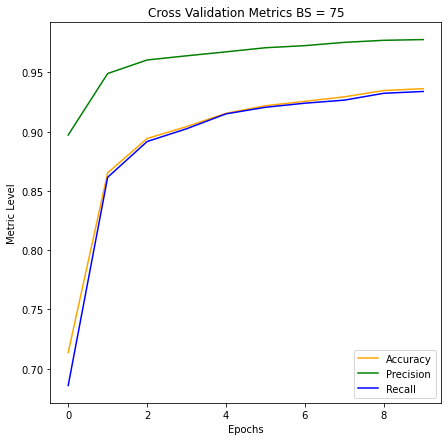

In [ ]:
eps = range(epochs)

plt.figure(figsize = (7, 7))
plt.plot(eps, acc, c = "orange", label = "Accuracy")
plt.plot(eps, pre, c = "green", label = "Precision")
plt.plot(eps, rec, c = "blue", label = "Recall")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Level")
plt.title("Cross Validation Metrics BS = {}".format(bs))
plt.savefig("CNN/batch_size_analysis/bs={}.png".format(bs))
plt.show()

## Training on the Training Split

The following block of code trains with optimized hyperparameters on the original training split from Kaggle.

In [ ]:
start_time = time.time()
with tf.device(gpu_name):
  net = CNN(Xtrain[0].shape)
  train(Xtrain, Ytrain, model = net, epochs = 10, learning_rate = 0.001, batch_size = 32)
print("Time Training:", time.time() - start_time)

Epoch 1/10
163/163 [==============================] - 26s 160ms/step - loss: 0.1174 - accuracy: 0.8232 - precision: 0.9419 - recall: 0.8121
Epoch 2/10
163/163 [==============================] - 26s 162ms/step - loss: 0.0595 - accuracy: 0.9176 - precision: 0.9741 - recall: 0.9133
Epoch 3/10
163/163 [==============================] - 26s 161ms/step - loss: 0.0488 - accuracy: 0.9323 - precision: 0.9780 - recall: 0.9298
Epoch 4/10
163/163 [==============================] - 26s 161ms/step - loss: 0.0398 - accuracy: 0.9450 - precision: 0.9820 - recall: 0.9432
Epoch 5/10
163/163 [==============================] - 26s 161ms/step - loss: 0.0350 - accuracy: 0.9523 - precision: 0.9861 - recall: 0.9492
Epoch 6/10
163/163 [==============================] - 26s 161ms/step - loss: 0.0300 - accuracy: 0.9599 - precision: 0.9883 - recall: 0.9574
Epoch 7/10
163/163 [==============================] - 26s 161ms/step - loss: 0.0296 - accuracy: 0.9567 - precision: 0.9882 - recall: 0.9530
Epoch 8/10
163/163 [

Evaluating the model against the training datatset. Please note that results may vary from those obtained on the report.

20/20 [==============================] - 1s 38ms/step - loss: 0.2287 - accuracy: 0.7260 - precision: 0.6973 - recall: 0.9923
Confusion Matrix:
[[ 66 168]
 [  3 387]]


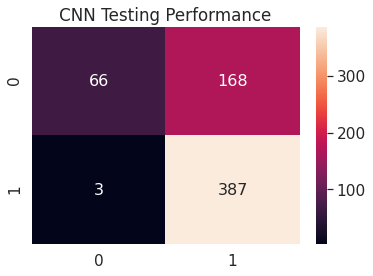

In [ ]:
net.evaluate(Xtest, Ytest)

ypreds = net.predict(Xtest)
y_class_preds = [0 if pred < 0.5 else 1 for pred in ypreds]

# Generate confusion matrix:
print("Confusion Matrix:")
print(metrics.confusion_matrix(Ytest, y_class_preds))

plot_cm(metrics.confusion_matrix(Ytest, y_class_preds), "CNN Testing Performance")

Now perform cross validation on the Training split with those hyperparameters.

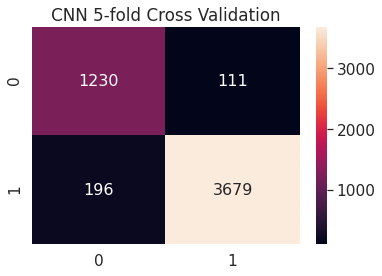

In [ ]:
# Performing 5-fold Cross Validation
cm = cv_confusion_matrix(CNN, train, Xtrain, Ytrain, folds = 5, epochs = 10)
plot_cm(cm, title = "CNN 5-fold Cross Validation")

##Training with Downsampling
In this block, we downsample the majority dataset (Pneumonia) using Synthetic Minority Oversampling Technique (SMOTE). This was donw in an effort to decrease the effect of the imbalanced nature of this dataset.

In [ ]:
with tf.device(gpu_name):
  # Load each split:
  Xtrain_ds = np.load("xray_dataset_pooled/train_processed.npy")
  Ytrain_ds = np.load("xray_dataset_pooled/train_labels.npy")

  Xtrain_flat = np.array([x.flatten() for x in Xtrain])
  sample_method = SMOTE('not minority')
  Xtrain_downsampled, Ytrain_downsampled = sample_method.fit_sample(Xtrain_flat, Ytrain_ds)

  Xtrain_downsampled = np.array([np.reshape(Xtrain_downsampled[i], (250, 175, 1)) / 255 for i in range(0, Xtrain_downsampled.shape[0])])

  Xval_ds = np.load("xray_dataset_pooled/val_processed.npy")
  Yval_ds = np.load("xray_dataset_pooled/val_labels.npy")

  # Instantiate the model and train:
  down_net = CNN(Xtrain_downsampled[0].shape)
  train(Xtrain_downsampled, Ytrain_downsampled, model = down_net, learning_rate = 0.001, epochs = 10)

As one can see in the subsequent block, this method does not yield better results than the class-weighting technique.

In [ ]:
Xtest = np.load("xray_dataset_pooled/test_processed.npy")
Ytest = np.load("xray_dataset_pooled/test_labels.npy")

Xtest = np.array([np.reshape(Xtest[i], (250, 175, 1)) / 255 for i in range(0, Xtest.shape[0])])

down_net.evaluate(Xtest, Ytest)

ypreds = net.predict(Xtest)
y_class_preds = [0 if pred < 0.5 else 1 for pred in ypreds]

# Generate confusion matrix:
print(metrics.confusion_matrix(Ytest, y_class_preds))

20/20 [==============================] - 1s 51ms/step - loss: 0.1554 - accuracy: 0.7772 - precision: 0.7381 - recall: 0.9974
[[ 96 138]
 [  1 389]]
